# Overview

Let's see how to use custom models on Civit platforms with diffusers.

In [1]:
!pip install diffusers==0.23.1
!pip install omegaconf==2.3.0
!pip install compel==2.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=b71e9b6d1f9e196d745f58b3cd0f554039355877a05155ece2e54a7ba031034f
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


Here we will download the custom model is based on `StableDiffusion V1.5`.

In [2]:
import os
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
civitai_key = user_secrets.get_secret("CIVITAI")

# https://education.civitai.com/civitais-guide-to-downloading-via-api/
os.environ["CHECKPOINT_MERGED"] = "meichidark_mix_v3.5.safetensors"
os.environ['CHECKPOINT_URL'] = "https://civitai.com/api/download/models/90778?&token="+civitai_key
os.environ["LORA_ADAPTER"] = "armor.safetensors"
os.environ["LORA_URL"]="https://civitai.com/api/download/models/224823?&token="+civitai_key

# Downloading the custom checkpoint(merged)

We download the merged checkpoint first.

In [3]:
!wget -q -O  ${CHECKPOINT_MERGED} ${CHECKPOINT_URL} --content-disposition 

In [4]:
!wget -q -O ${LORA_ADAPTER} ${LORA_URL} --content-disposition

# Loading the custom checkpoint(merged)

In [5]:
from diffusers import StableDiffusionPipeline
import torch

# Loading the pretrained checkpoint(merged) from downloaded safetensors
pipe=StableDiffusionPipeline.from_single_file(
    os.getenv('CHECKPOINT_MERGED'),
    use_safetensors=True,
    torch_dtype=torch.float16 # For CUDA
)
pipe.enable_model_cpu_offload()
pipe

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-02-05 10:27:59.837241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 10:27:59.837368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 10:27:59.991134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.55k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:749: FutureWarning: `torch_dtype` is deprecated and will be removed in version 0.25.0. 
  deprecate("torch_dtype", "0.25.0", "")


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.23.1",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# Loading the custom LoRA

Here we only use one Lora adapter, it can also support using multiple adapters.

```python
# Using multiple LoRAs with different scaling factors.

lora_dirs = ["lora1.safetensors", "lora2.safetensors", ...]
lora_scales = [0.7, 0.7, ...]

ldir, lsc in zip(lora_dirs, lora_scales):
    # Iteratively add new LoRA.
    pipe.load_lora_weights(ldir)
    # And scale them accordingly.
    pipe.fuse_lora(lora_scale = lsc)
```

In [6]:
pipe.load_lora_weights(os.getenv('LORA_ADAPTER'))
pipe

/opt/conda/lib/python3.10/site-packages/diffusers/loaders.py:1905: FutureWarning: `_modify_text_encoder` is deprecated and will be removed in version 0.25. You are using an old version of LoRA backend. This will be deprecated in the next releases in favor of PEFT make sure to install the latest PEFT and transformers packages in the future.
  deprecate("_modify_text_encoder", "0.25", LORA_DEPRECATION_MESSAGE)
/opt/conda/lib/python3.10/site-packages/diffusers/loaders.py:1876: FutureWarning: `_remove_text_encoder_monkey_patch_classmethod` is deprecated and will be removed in version 0.25. You are using an old version of LoRA backend. This will be deprecated in the next releases in favor of PEFT make sure to install the latest PEFT and transformers packages in the future.
  deprecate("_remove_text_encoder_monkey_patch_classmethod", "0.25", LORA_DEPRECATION_MESSAGE)


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.23.1",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# Setting Clip_skip

In [7]:
clip_skip=2
pipe.text_encoder.text_model.encoder.layers=pipe.text_encoder.text_model.encoder.layers[:-clip_skip]
pipe.safety_checker=None

# Loading scheduler

In [8]:
from diffusers import (EulerAncestralDiscreteScheduler,
                       EulerDiscreteScheduler,
                       DPMSolverMultistepScheduler)
scheduler='none'

if scheduler=='EDS':
    pipe.scheduler= EulerDiscreteScheduler.from_config(pipe.scheduler.config)
elif scheduler=='EADS':
    pipe.scheduler=EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
else:
    pipe.scheduler=DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to('cuda')
pipe

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokenizer, unet, scheduler, safety_checker, feature_extractor to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.23.1",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# Preprocess the prompt

We want to overcome the 77 tokens limit. So, we use [compel](https://github.com/damian0815/compel) to embedding the prompts to a PyTorch tensor.

In [9]:
from compel import Compel


embeddings=True

prompt='((a female wearing a red hood)), fantasy theme, medieval, fierce look, ((dynamic poses)), tattoo on her arms, white ruffled sleeve shirt, choker,  gloves, corset, leather pants, belt, waist sash, cape,  (((masterpiece))),  ((best quality)), ((intricate detailed)), ((Hyperrealistic)), a woman with perfect body figure wearing cyberpunk cloth, pale skin, ((huge breast)),  highly detailed, illustration, perfect hands, detailed fingers, beautiful detailed eyes, red hair, black hair, multiple color hair, long hair, (fantasy:1.2),  armor, detailed background, tavern , night, light by candle, lens flare, tempting look, looking at the viewer, from above,  <lora:adventurers_v1:1>  <lora:sxz-niji-v2:0.6>'
negative_prompt='easynegative, badhandv4, (low quality, worst quality:1.4), poorly drawn hands, bad anatomy, monochrome, { long body }, bad anatomy, liquid body, malformed, mutated, anatomical nonsense, bad proportions, uncoordinated body, unnatural body, disfigured, ugly, gross proportions, mutation, disfigured, deformed, { mutation}, {poorlydrawn}, bad hand, mutated hand, bad fingers, mutated fingers,   badhandv4, liquid tongue, long neck, fused ears, bad ears, poorly drawn ears, extra ears, liquid ears, heavy ears, missing ears, fused animal ears, bad animal ears, poorly drawn animal ears, extra animal ears, liquid animal ears, heavy animal ears, missing animal ears, bad hairs, poorly drawn hairs, fused hairs, bad face, fused face, poorly drawn face, cloned face, big face, long face, bad eyes, fused eyes poorly drawn eyes, extra eyes, bad mouth, fused mouth, poorly drawn mouth, bad tongue, big mouth, bad perspective, bad objects placement, NSFW, bad weapon, fused weapon, extra weapons, poorly weapon, bad sword, poor sword'


compel=Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)
con_embeds=compel([prompt])
neg_embeds=compel([negative_prompt])

print(con_embeds.size())
print(neg_embeds.size())


# Warning
# Below function will cause the different size of two prompts(con, neg_promt)

# max_length=pipe.tokenizer.model_max_length
# def get_prompt_embeddings(prompt, negative_prompt):
#     count_prompt=len(prompt.split(' '))
#     count_negative_prompt=len(prompt.split(' '))
    
#     if count_prompt>=count_negative_prompt:
#         input_ids=pipe.tokenizer(prompt, 
#                                   truncation=False, 
#                                   return_tensors='pt').input_ids.to('cuda')
#         shape_max_length=input_ids.shape[-1]
        
#         negative_ids=pipe.tokenizer(negative_prompt, truncation=False, 
#                                     padding='max_length', 
#                                     max_length=shape_max_length, 
#                                     return_tensors='pt').input_ids.to('cuda')
#     else:
#         negative_ids=pipe.tokenizer(negative_prompt, truncation=False,
#                                    return_tensors='pt').input_ids.to('cuda')
#         shape_max_length=negative_ids.shape[-1]
#         input_ids=pipe.tokenizer(prompt, truncation=False,
#                                 padding='max_length',
#                                 max_length=shape_max_length,
#                                 return_tensors='pt').input_ids.to('cuda')
        
#     concat_embeds=[]
#     neg_embeds=[]
#     for i in range(0,shape_max_length, max_length):
#         concat_embeds.append(pipe.text_encoder(input_ids[:,i:i+max_length])[0])
#         neg_embeds.append(pipe.text_encoder(negative_ids[:,i:i+max_length])[0])
    
#     prompt_embeddings=torch.cat(concat_embeds, dim=1)
#     negative_prompt_embeddings=torch.cat(neg_embeds, dim=1)
    
#     return prompt_embeddings, negative_prompt_embeddings

# if embeddings:
#     prompt_embed, negative_embed=get_prompt_embeddings(prompt, negative_prompt)
# print(prompt_embed.size())
# print(negative_embed.size())

torch.Size([1, 77, 768])
torch.Size([1, 77, 768])


  0%|          | 0/35 [00:00<?, ?it/s]

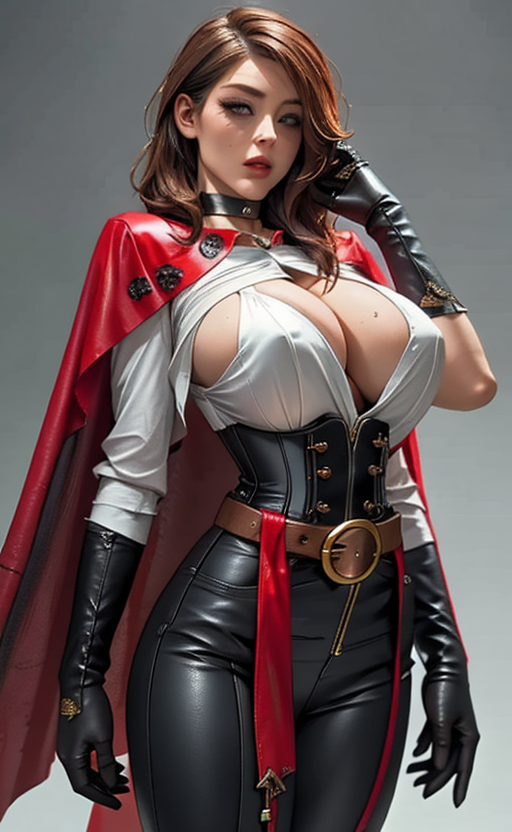

In [10]:
if embeddings:
    imgs=pipe(prompt_embeds=con_embeds,
             negative_prompt_embeds=neg_embeds,
             width=512,
             height=832,
             guidance_scale=7.0,
             num_inference_steps=35,
             num_images_per_prompt=1,
             generator=torch.manual_seed(93421173)).images
else:
    imgs=pipe(prompt=prompt,
              negative_prompt=negative_prompt,
              width=512,height=832,
              guidance_scale=12.0,num_inference_steps=50,
              num_images_per_prompt=1,
              generator=torch.manual_seed(0)).images
imgs[0]